In [5]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import pyproj as proj
import scipy.spatial as spat
from datetime import datetime, timedelta

In [6]:
import os
import sys

sys.path.append("../")
from src import visualization as vis
from src import data

In [7]:
def get_files_for_year(basedir, year, fname):
    return glob.glob("{}/{}/**/{}.nc".format(basedir, year, fname))

def concatenate_months(ncfiles, variables, dims):
    master_vars = []
    for v, d in zip(variables, dims):
        va = np.zeros(shape=(d, 1))
        master_vars.append(va)
        
    months = np.zeros(shape=(1,))
        
    for f in ncfiles:
        print(f)
        month = int(f.split("/")[-2].split(".")[0].split("_")[-1])
        
        dset = nc.Dataset(f)
        
        size = dset.dimensions['nlag'].size
        
        for i, v in enumerate(variables):
            var = dset[v][:].data
            mv = master_vars[i]
            mv = np.concatenate((mv, var), axis=1)
            master_vars[i] = mv
            
        ms = np.full((size,), month)
        
        months = np.concatenate((months, ms), axis=0)
            
        dset.close()
        
    master_vars.append(months)
            
    return master_vars

def concatenate_years(years, basedir, fname, variables, dims):
    
    master_vars = []
    for v, d in zip(variables, dims):
        va = np.zeros(shape=(d, 1))
        master_vars.append(va)
    
    for y in years:
        f = "{}/{}/annual.nc".format(basedir, y)
        print(f)
        dset = nc.Dataset(f)
        
        for i, v in enumerate(variables):
            var = dset[v][:].data
            mv = master_vars[i]
            mv = np.concatenate((mv, var), axis=1)
            master_vars[i] = mv
            
        dset.close()
            
    return master_vars
        

In [8]:
def set_plds(pld_min, pld_max, num):
    
    pld_mean = (pld_min+pld_max)/2
    
    pld_mins = np.random.randint(pld_min, pld_mean, size=num).tolist()
    pld_maxs = np.random.randint(pld_mean, pld_max, size=num).tolist()
    pld_ranges = list(zip(pld_mins, pld_maxs))

    return pld_mins, pld_maxs, pld_ranges

def build_tree(months, xs, ys):
    
    grid_points = np.dstack([months.ravel(), xs.ravel(), ys.ravel()])[0]
    tree = spat.cKDTree(grid_points)
    return tree

In [5]:
prediction_data = pd.read_csv("../auxdata/settlement_prediction_area_region_base.csv")
prediction_data = prediction_data[prediction_data.year == 1984]
pred_months, pred_xs, pred_ys = prediction_data['month'].to_numpy(), prediction_data['x'].to_numpy(), prediction_data['y'].to_numpy()
prediction_vals = prediction_data['pred_std'].to_numpy()

In [6]:
prediction_data.head()

,Unnamed: 0,REGION_NAM,x,y,year,month,predicted,species,pred_std,period,area,lon,lat
0,1,Scotian Shelf,1705179.500,414890.34375,1984,1,0.008502,Atlantic Cod,0.033799,base,52.111510,-59.752682,46.090115
1,2,Scotian Shelf,1709910.000,409690.18750,1984,1,0.008893,Atlantic Cod,0.035353,base,46.267913,-59.701325,46.038551
2,3,Scotian Shelf,1715777.875,403368.03125,1984,1,0.056401,Atlantic Cod,0.224205,base,78.884519,-59.637532,45.975704
3,4,Scotian Shelf,1722603.125,395906.81250,1984,1,0.096601,Atlantic Cod,0.384010,base,90.248901,-59.563690,45.901623
4,5,Scotian Shelf,1730039.125,387611.34375,1984,1,0.028223,Atlantic Cod,0.112193,base,101.606672,-59.483742,45.819405


In [353]:
tree = build_tree(pred_months, pred_xs, pred_ys)

In [9]:
def settle(species, pred_species, year, pldmin, pldmax):
    
    pred_fname = "../auxdata/settlement_prediction_area_region_base.csv" if year < 2000 else "../auxdata/settlement_prediction_area_region_warm.csv"
    
    prediction_data = pd.read_csv(pred_fname)
    prediction_data = prediction_data[(prediction_data.year == year) & (prediction_data.species == pred_species)]
    pred_months, pred_xs, pred_ys = prediction_data['month'].to_numpy(), prediction_data['x'].to_numpy(), prediction_data['y'].to_numpy()
    prediction_vals = prediction_data['pred_std'].to_numpy()
    
    tree = build_tree(pred_months, pred_xs, pred_ys)
    
    fname="../data/model_sims/baseline/{}/{}/annual.nc".format(species, year) if year < 2000 else "../data/model_sims/warm/{}/{}/annual.nc".format(species, year)
    dset = nc.Dataset(fname)

    xs, ys, months = dset['x'][:].data, dset['y'][:].data, dset['month'][:].data
    xs, ys, months = xs[:, 1:], ys[:, 1:], months[1:]

    num_particles = len(xs[0, :])
    print(num_particles)

    # Store init data
    init_times_scaled_dict = {}
    init_times_raw_dict = {}
    init_xs_dict = {}
    init_ys_dict = {}

    for m in range(1, 13):
        mo = str(m).zfill(2)
        init_file = "/".join(fname.split("/")[:-1])+"/{}/particle_init_{}{}.txt".format(mo, year, mo)
        try:
            init_data = np.loadtxt(init_file, skiprows=1)
            init_times = (init_data[:, 4]/24 - 1).astype(int)
            init_times_scaled = init_times - np.min(init_times)
            init_xs = init_data[:, 1].astype(int)
            init_ys = init_data[:, 2].astype(int)


            init_times_raw_dict[mo] = init_times.tolist()
            init_times_scaled_dict[mo] = init_times_scaled.tolist()
            init_xs_dict[mo] = init_xs.tolist()
            init_ys_dict[mo] = init_ys.tolist()

        except Exception:
            continue

    # Loop through all of the particles
    _, _, pld_ranges = set_plds(pldmin, pldmax, num_particles)

    num_settled = 0
    init_xs = np.empty(shape=(num_particles))
    init_ys = np.empty(shape=(num_particles))
    init_ts = np.empty(shape=(num_particles))

    final_xs = np.empty(shape=(num_particles))
    final_ys = np.empty(shape=(num_particles))
    final_ts = np.empty(shape=(num_particles))

    settled  = np.zeros(shape=(num_particles)) 

    for n in range(num_particles):
        if n % 10000 == 0:
            print(n)
            
        m = months[n]

        mo = str(m).zfill(2)
        
#         if xs[0, n] == 0:
#             print("Found a weird 0.")
#             continue

        pld_min, pld_max = pld_ranges[n]
        try:
            release_day = init_times_scaled_dict[mo].pop(0)
            raw_day = init_times_raw_dict[mo].pop(0)

            init_xs[n] = init_xs_dict[mo].pop(0)
            init_ys[n] = init_ys_dict[mo].pop(0)
            init_ts[n] = raw_day
        except Exception:
            continue

        for t in range(pld_min, pld_max+1):
            t_real = t+release_day
            t_raw = t+raw_day
            x, y = xs[t_real, n], ys[t_real, n]
            m = (datetime(year, 1, 1) + timedelta(int(t_raw)+1)).month

            dist, idx = tree.query([m, x, y])
            pred = prediction_vals[idx]

            rv = np.random.uniform(0, 1)

            final_xs[n] = x
            final_ys[n] = y
            final_ts[n] = t_raw

            if rv >= (1-pred):
                settled[n] = 1
                continue;
        
    return fname, num_particles, init_xs, init_ys, init_ts, final_xs, final_ys, final_ts, settled

def write_settlement_file(fname, num_particles, init_xs, init_ys, init_ts, final_xs, final_ys, final_ts, settled):
    # Write data to file
    settlement_file = "/".join(fname.split("/")[:-1])+"/settlement.nc"
    if os.path.exists(settlement_file):
        os.remove(settlement_file)

    print(settlement_file)

    sett_f = nc.Dataset(settlement_file, 'w', format="NETCDF4")

    sett_f.createDimension('num_particles', num_particles)

    init_lons_var    = sett_f.createVariable("init_lons",    "f8", ("num_particles",))
    init_lats_var    = sett_f.createVariable("init_lats",    "f8", ("num_particles",))
    init_times_var   = sett_f.createVariable("init_times",   "f8", ("num_particles",))

    final_lons_var   = sett_f.createVariable("final_lons",   "f8", ("num_particles",))
    final_lats_var   = sett_f.createVariable("final_lats",   "f8", ("num_particles",))
    final_times_var  = sett_f.createVariable("final_times",  "f8", ("num_particles",))

    settled_particles_var   = sett_f.createVariable("settled_particles",   "u1", ("num_particles",))

    init_lons_var[:] = init_xs
    init_lats_var[:] = init_ys
    init_times_var[:] = init_ts

    final_lons_var[:] = final_xs
    final_lats_var[:] = final_ys
    final_times_var[:] = final_ts

    settled_particles_var[:] = settled

    sett_f.close()

In [10]:
species = "haddock"
for y in range(2012, 2017):
    print(y)
    fname, num_particles, init_xs, init_ys, init_ts, final_xs, final_ys, final_ts, settled = settle("american-butterfish", "American Butterfish", y, 33, 55)
    write_settlement_file(fname, num_particles, init_xs, init_ys, init_ts, final_xs, final_ys, final_ts, settled)

2012
997947
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
../data/model_sims/warm/american-butterfish/2012/settlement.nc
2013
998343
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340

In [17]:
fname="../data/model_sims/baseline/{}/{}/annual.nc".format("yellowtail-flounder", 1985)

init_times_scaled_dict = {}
init_times_raw_dict = {}
init_xs_dict = {}
init_ys_dict = {}

for m in range(1, 13):
    mo = str(m).zfill(2)
    init_file = "/".join(fname.split("/")[:-1])+"/{}/particle_init_{}{}.txt".format(mo, 1985, mo)
    try:
        init_data = np.loadtxt(init_file, skiprows=1)
        init_times = (init_data[:, 4]/24 - 1).astype(int)
        init_times_scaled = init_times - np.min(init_times)
        init_xs = init_data[:, 1].astype(int)
        init_ys = init_data[:, 2].astype(int)


        init_times_raw_dict[mo] = init_times.tolist()
        init_times_scaled_dict[mo] = init_times_scaled.tolist()
        init_xs_dict[mo] = init_xs.tolist()
        init_ys_dict[mo] = init_ys.tolist()

    except Exception:
        continue

In [18]:
from collections import Counter

In [19]:
dset=nc.Dataset(fname)

In [20]:
Counter(dset['month'][1:].data)

Counter({5: 431559, 4: 440228, 3: 68859, 6: 56592})

In [21]:
np.where(dset['x'][0, 1:].data == 0)

(array([431559]),)

In [27]:
len(init_times_scaled_dict['03']), len(init_times_scaled_dict['04']), len(init_times_scaled_dict['05']), len(init_times_scaled_dict['06']),  

(68860, 440226, 431560, 56593)

In [23]:
len(init_times_scaled_dict['05']), len(dset['month'][1:].data)

(431560, 997238)

In [56]:
d = np.loadtxt("../data/model_sims/warm/atlantic-cod/2012/03/particle_init_201203.txt", skiprows=1)
len(d)

462778

In [142]:
import matplotlib.pyplot as plt

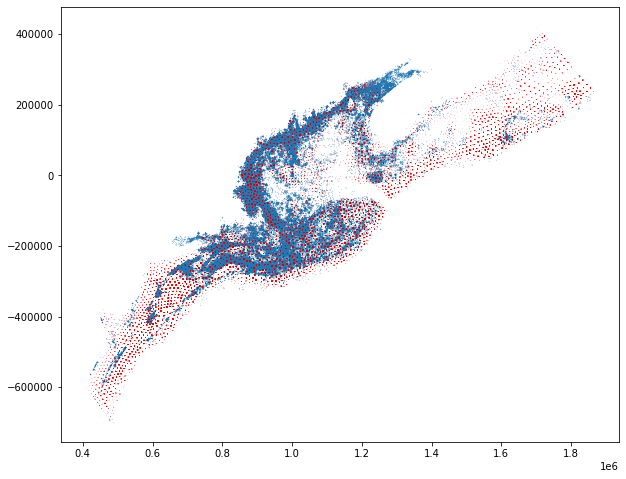

In [285]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(settled_xs, settled_ys, s=0.01)
ax.scatter(init_xs, init_ys, s=0.01, c="red", alpha=0.1)

In [201]:
from src import data_products as dp

In [286]:
h, xe, ye = dp.compute_larvae_density(settled_xs, settled_ys, nbins=300)

In [205]:
def plot_density(h, xe, ye, ax=None, **kwargs):

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(18,8))

    im = ax.imshow(h, interpolation='nearest', origin='lower', extent=[xe[0], xe[-1], ye[0], ye[-1]], **kwargs)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    return ax, im

/vortexfs1/home/jzahner/.conda/envs/larval-dispersal-modeling/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>,
 <matplotlib.image.AxesImage at 0x2aaaebdb5390>)

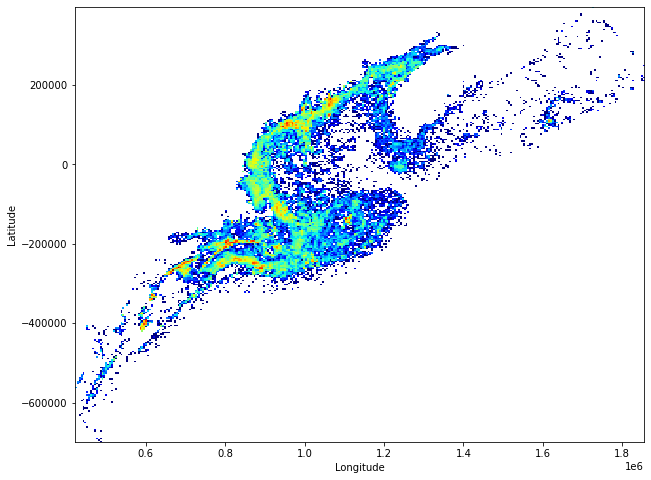

In [287]:
plot_density(np.log10(h.T), xe, ye, cmap="jet")

In [335]:
sett_data = nc.Dataset("../data/model_sims/baseline/haddock/1984/settlement.nc")
xs, ys = sett_data["final_lons"][:].data, sett_data["final_lats"][:].data
settled = sett_data["settled_particles"][:].data
xs_sett, ys_sett = ma.MaskedArray(xs, mask=settled), ma.MaskedArray(ys, mask=settled)
xs_sett, ys_sett = xs_sett[xs_sett.mask].data, ys_sett[ys_sett.mask].data

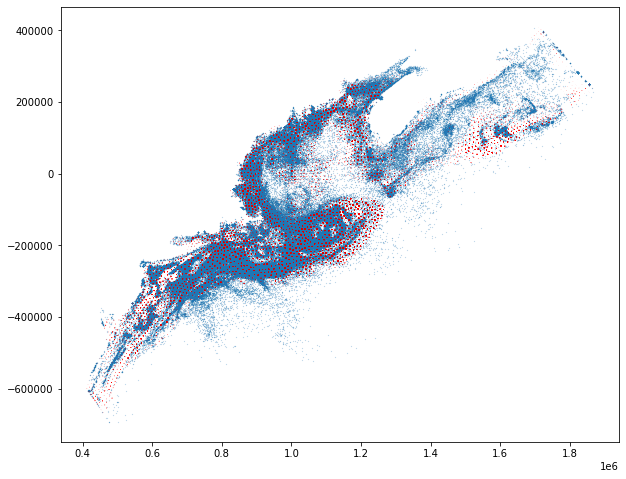

In [336]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(xs_sett, ys_sett, s=0.01)
ax.scatter(init_xs, init_ys, s=0.01, c="red", alpha=0.1)

In [315]:
import numpy.ma as ma

In [337]:
sett_data = nc.Dataset("../data/model_sims/baseline/haddock/1985/settlement.nc")
xs, ys = sett_data["final_lons"][:].data, sett_data["final_lats"][:].data
settled = sett_data["settled_particles"][:].data
xs_sett, ys_sett = ma.MaskedArray(xs, mask=settled), ma.MaskedArray(ys, mask=settled)
xs_sett, ys_sett = xs_sett[xs_sett.mask].data, ys_sett[ys_sett.mask].data

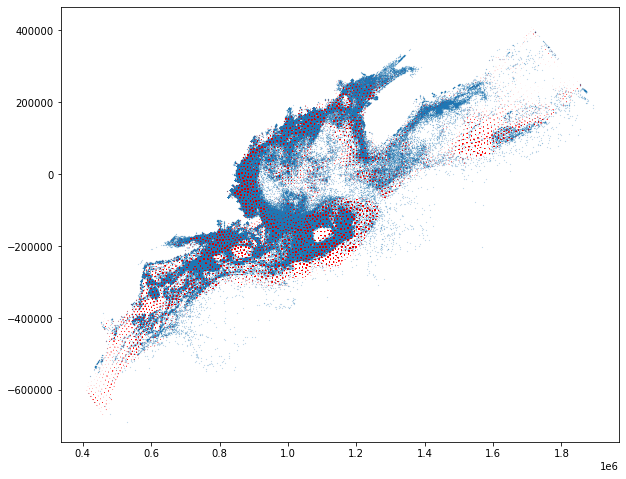

In [338]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(xs_sett, ys_sett, s=0.01)
ax.scatter(init_xs, init_ys, s=0.01, c="red", alpha=0.1)

In [340]:
sett_data = nc.Dataset("../data/model_sims/baseline/haddock/1986/settlement.nc")
xs, ys = sett_data["final_lons"][:].data, sett_data["final_lats"][:].data
settled = sett_data["settled_particles"][:].data
xs_sett, ys_sett = ma.MaskedArray(xs, mask=settled), ma.MaskedArray(ys, mask=settled)
xs_sett, ys_sett = xs_sett[xs_sett.mask].data, ys_sett[ys_sett.mask].data

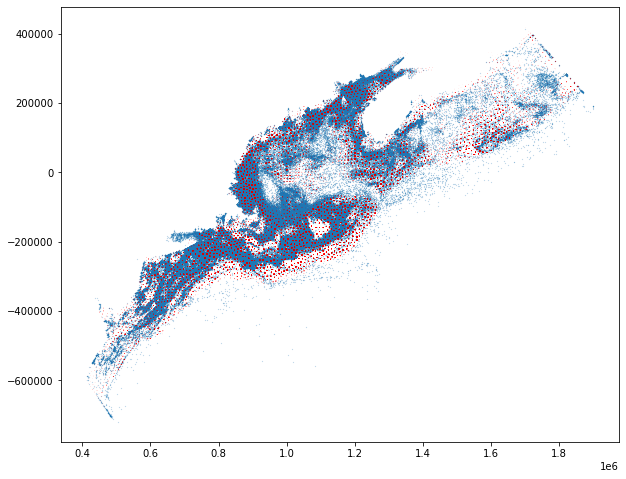

In [341]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(xs_sett, ys_sett, s=0.01)
ax.scatter(init_xs, init_ys, s=0.01, c="red", alpha=0.1)

In [343]:
sett_data = nc.Dataset("../data/model_sims/baseline/haddock/1987/settlement.nc")
xs, ys = sett_data["final_lons"][:].data, sett_data["final_lats"][:].data
settled = sett_data["settled_particles"][:].data
xs_sett, ys_sett = ma.MaskedArray(xs, mask=settled), ma.MaskedArray(ys, mask=settled)
xs_sett, ys_sett = xs_sett[xs_sett.mask].data, ys_sett[ys_sett.mask].data

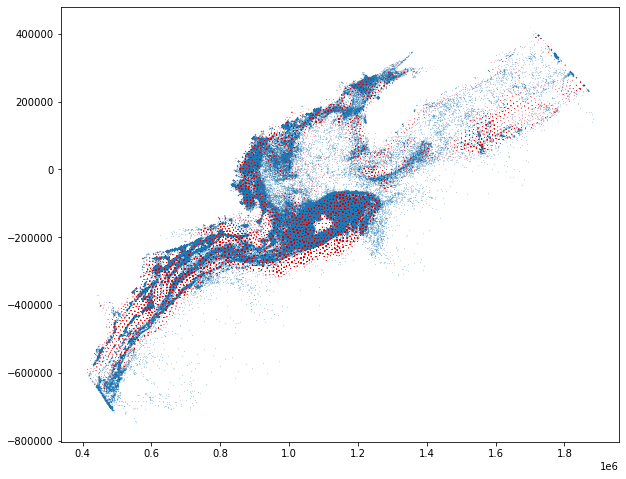

In [344]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(xs_sett, ys_sett, s=0.01)
ax.scatter(init_xs, init_ys, s=0.01, c="red", alpha=0.1)

In [ ]:
sett_data = nc.Dataset("../data/model_sims/baseline/haddock/1987/settlement.nc")
xs, ys = sett_data["final_lons"][:].data, sett_data["final_lats"][:].data
settled = sett_data["settled_particles"][:].data
xs_sett, ys_sett = ma.MaskedArray(xs, mask=settled), ma.MaskedArray(ys, mask=settled)
xs_sett, ys_sett = xs_sett[xs_sett.mask].data, ys_sett[ys_sett.mask].data